# I. Set Up

In [1]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math
import statistics
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from pathlib import Path
import glob
import os
import ipywidgets as widgets
from IPython.display import clear_output
import sys
import time
import json
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import seaborn as sns
import fnmatch
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.neighbors import NearestNeighbors
import random
import dcor
import re
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
from sherpa.astro import ui
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
# CUSTOM Imports
from data_extraction_functions import *
from data_exploration_functions import *
from data_representation_functions import *

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Custom object hook to convert lists of lists to NumPy arrays
def numpy_hook(obj):
    if isinstance(obj, list):
        # Check if the list contains sublists (i.e. a matrix)
        if isinstance(obj[0], list):
            # Convert the list of lists to a NumPy array matrix
            return np.array(obj)
    # Return all other objects as is
    return obj

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

2023-04-05 16:37:54.142288: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Dropdown(description='Set :', options=('All', 'Bona'), value='All')

# II. Load Data

In [2]:
# Set ID
set_id = set_widget.value
# Select Input
files = os.listdir(f'{global_path}/{set_id}/')
input_files = [f for f in files if fnmatch.fnmatch(f, 'hist3D*nE16*.pkl')]
input_widget = widgets.Dropdown(options=input_files[:],value=input_files[0],description='Hist File :',disabled=False); input_widget


Dropdown(description='Hist File :', options=('hist3D-All-nE16-nt24-ndt24-normnone.pkl', 'hist3D-All-nE16-nt24-…

In [3]:
# Load the DataFrame from the CSV file
input_file = input_widget.value
# Load histogram dictionary
with open(f'{global_path}/{set_id}/{input_file}', 'rb') as f:
    hist_dict = pickle.load(f)
# Flatten histograms in the dictionary and get IDs
ids = hist_dict.keys()
histograms = hist_dict.values()
features = np.array([np.array(h).flatten() for h in histograms])
features[np.isnan(features)] = 0.0
# Load properties
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id}.csv')
df_properties_input = df_properties_input[df_properties_input['obsreg_id'].isin(list(ids))]
df_properties = df_properties_input.drop_duplicates('obsreg_id', keep='first').reset_index()

# Print eventfiles and properties number of IDs
print("Number of Features: ", len(features))
print("Number of Property Sets: ", len(df_properties))

# Select only the columns you need as labels from df_properties
df_label = df_properties[['obsreg_id','hard_hm', 'hard_hs', 'hard_ms', 'var_prob_b', 'var_prob_h', 'var_prob_m', 'var_prob_s']]
mask_nonan = df_label.notna().all(axis=1)
index_nonan = list(df_label.notna().all(axis=1).index[df_label.notna().all(axis=1)])
df_label = df_label[mask_nonan]
ID = df_label['obsreg_id'].values
XX = features[(index_nonan),:]
df_yy = df_label[['hard_hm', 'hard_hs', 'hard_ms', 'var_prob_b', 'var_prob_h', 'var_prob_m', 'var_prob_s']]
YY = df_yy.values
print(len(XX),len(YY))
# More filters to get reduced dataset
reduce = 4
df_label1 = df_label.loc[(df_label.var_prob_b < 0.25) & (df_label.var_prob_b >= 0) & (df_label.hard_hs < -0.5) & (df_label.hard_hs >= -1)]
df_label1 = df_label1.sample(n=round(len(df_label1)/reduce))
df_label2 = df_label.loc[(df_label.var_prob_b < 0.25) & (df_label.var_prob_b >= 0) & (df_label.hard_hs < 0) & (df_label.hard_hs >= -0.5)]
df_label2 = df_label2.sample(n=round(len(df_label2)/reduce))
df_label3 = df_label.loc[(df_label.var_prob_b < 0.25) & (df_label.var_prob_b >= 0) & (df_label.hard_hs < 0.5) & (df_label.hard_hs >= 0)]
df_label3 = df_label3.sample(n=round(len(df_label3)/reduce))
df_label4 = df_label.loc[(df_label.var_prob_b < 0.25) & (df_label.var_prob_b >= 0) & (df_label.hard_hs <= 1) & (df_label.hard_hs >= 0.5)]
df_label4 = df_label4.sample(n=round(len(df_label4)/reduce))

df_label5 = df_label.loc[(df_label.var_prob_b < 0.5) & (df_label.var_prob_b >= 0.25) & (df_label.hard_hs < -0.5) & (df_label.hard_hs >= -1)]
df_label5 = df_label5.sample(n=round(len(df_label5)/reduce))
df_label6 = df_label.loc[(df_label.var_prob_b < 0.5) & (df_label.var_prob_b >= 0.25) & (df_label.hard_hs < 0) & (df_label.hard_hs >= -0.5)]
df_label6 = df_label6.sample(n=round(len(df_label6)/reduce))
df_label7 = df_label.loc[(df_label.var_prob_b < 0.5) & (df_label.var_prob_b >= 0.25) & (df_label.hard_hs < 0.5) & (df_label.hard_hs >= 0)]
df_label7 = df_label7.sample(n=round(len(df_label7)/reduce))
df_label8 = df_label.loc[(df_label.var_prob_b < 0.5) & (df_label.var_prob_b >= 0.25) & (df_label.hard_hs <= 1) & (df_label.hard_hs >= 0.5)]
df_label8 = df_label8.sample(n=round(len(df_label8)/reduce))

df_label9 = df_label.loc[(df_label.var_prob_b < 0.75) & (df_label.var_prob_b >= 0.5) & (df_label.hard_hs < -0.5) & (df_label.hard_hs >= -1)]
df_label9 = df_label9.sample(n=round(len(df_label9)/reduce))
df_label10 = df_label.loc[(df_label.var_prob_b < 0.75) & (df_label.var_prob_b >= 0.5) & (df_label.hard_hs < 0) & (df_label.hard_hs >= -0.5)]
df_label10 = df_label10.sample(n=round(len(df_label10)/reduce))
df_label11 = df_label.loc[(df_label.var_prob_b < 0.75) & (df_label.var_prob_b >= 0.5) & (df_label.hard_hs < 0.5) & (df_label.hard_hs >= 0)]
df_label11 = df_label11.sample(n=round(len(df_label11)/reduce))
df_label12 = df_label.loc[(df_label.var_prob_b < 0.75) & (df_label.var_prob_b >= 0.5) & (df_label.hard_hs <= 1) & (df_label.hard_hs >= 0.5)]
df_label12 = df_label12.sample(n=round(len(df_label12)/reduce))

df_label13 = df_label.loc[(df_label.var_prob_b <= 1) & (df_label.var_prob_b >= 0.75) & (df_label.hard_hs < -0.5) & (df_label.hard_hs >= -1)]
df_label13 = df_label13.sample(n=round(len(df_label13)/reduce))
df_label14 = df_label.loc[(df_label.var_prob_b <= 1) & (df_label.var_prob_b >= 0.75) & (df_label.hard_hs < 0) & (df_label.hard_hs >= -0.5)]
df_label14 = df_label14.sample(n=round(len(df_label14)/reduce))
df_label15 = df_label.loc[(df_label.var_prob_b <= 1) & (df_label.var_prob_b >= 0.75) & (df_label.hard_hs < 0.5) & (df_label.hard_hs >= 0)]
df_label15 = df_label15.sample(n=round(len(df_label15)/reduce))
df_label16 = df_label.loc[(df_label.var_prob_b <= 1) & (df_label.var_prob_b >= 0.75) & (df_label.hard_hs <= 1) & (df_label.hard_hs >= 0.5)]
df_label16 = df_label16.sample(n=round(len(df_label16)/reduce))

print(len(df_label1),len(df_label2),len(df_label3),len(df_label4),len(df_label5),len(df_label6),len(df_label7),len(df_label8),len(df_label9),len(df_label10),len(df_label11),len(df_label12),len(df_label13),len(df_label14),len(df_label15),len(df_label16))
# More filters to get reduced dataset
df_final_label = pd.concat([df_label1,df_label2, df_label3, df_label4, df_label5, df_label6, df_label7, df_label8, df_label9, df_label10, df_label11, df_label12,df_label13,df_label14,df_label15,df_label16])
df_final_label = df_final_label.sort_values('obsreg_id')
index_final = list(df_final_label.index)
ID = df_final_label['obsreg_id'].values
X = features[(index_final),:]
# Scale the labels to the same range as the data
df_y = df_final_label[['hard_hm', 'hard_hs', 'hard_ms', 'var_prob_b', 'var_prob_h', 'var_prob_m', 'var_prob_s']]
Y = df_y.values
print('Length X:', len(X))
print('Length Y:', len(Y))
df_final_label.head()


Number of Features:  82283
Number of Property Sets:  82283
51830 51830
730 3912 2047 423 248 1492 835 136 145 699 420 80 412 724 435 218
Length X: 12956
Length Y: 12956


,obsreg_id,hard_hm,hard_hs,hard_ms,var_prob_b,var_prob_h,var_prob_m,var_prob_s
1,10004_1,0.398501,0.488445,0.094941,0.524820,0.127010,0.676527,0.485168
3,10025_72,0.058713,-0.103685,-0.162399,0.105254,0.252282,0.650681,0.283007
11,10037_40,0.028732,0.338538,0.309806,0.119011,0.438140,0.236688,0.551795
54,10060_48,0.432230,0.657089,0.311056,0.118958,0.098020,0.882063,0.510334
66,10062_210,-0.287320,-0.858214,-0.754528,0.050795,0.751388,0.581723,0.220156


# III. PCA Optimisation?

Elbow Point (36,6 -> 21 for 2D // 671,12 -> 341/2 (121,12 -> 66/67 for 0.005 and 0.9) ) for 0.005 and 0.95 (NOTE THIS IS ON THE 50000, not all) 

In [5]:
# Define Colour Scheme
google_blue = '#4285F4'
google_red = '#DB4437'
google_yellow = '#F4B400'
google_green = '#0F9D58'
google_purple = '#6f2da8'

# PCA
npca = 50
pca = PCA(npca)
Xpca = pca.fit_transform(features) 
# Compute the size of the eigenvalues and the cumulative relative variance
eigenvalues = pca.explained_variance_
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100


34
85.34472844697052


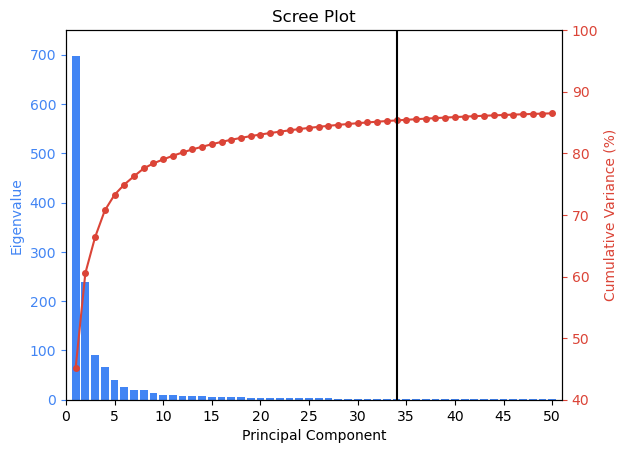

In [6]:
# Plot the scree plot and the cumulative variance plot on the same figure
fig, ax1 = plt.subplots()

# Plot the scree plot
ax1.bar(range(len(eigenvalues)), eigenvalues, alpha=1, color = google_blue)
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Eigenvalue')
ax1.set_title('Scree Plot')
ax1.yaxis.label.set_color(google_blue)
ax1.tick_params(axis='y', colors=google_blue)
ax1.set_ylim([0, 750])
ax1.set_xlim([-1, 50])
ax1.set_xticks(range(-1,len(eigenvalues),5))
ax1.set_xticklabels([i+1 for i in range(-1,len(eigenvalues),5)])

# Create a twin y-axis for the cumulative variance plot
ax2 = ax1.twinx()

# Plot the cumulative variance plot
ax2.plot(cumulative_variance, c=google_red, linestyle='-', marker='.', markersize=8)
ax2.set_ylabel('Cumulative Variance (%)')
ax2.yaxis.label.set_color(google_red)
ax2.tick_params(axis='y', colors=google_red)
ax2.set_ylim([40, 100])

# Plot Knee
knee_point = np.argmax(np.diff(cumulative_variance) <= 0.1) +1
variance = cumulative_variance[knee_point-1]
print(knee_point)
print(variance)
plt.axvline(x=knee_point-1, color='black')
# plt.axvline(x=n_components95-1, color='black')
# plt.axvline(x=avg, color='black')

# Show the figure
plt.show()

# III. TSNE Runs

In [44]:
# Compute the inverse covariance matrix
covariance_matrix = np.cov(Y, rowvar=False)
inverse_covariance_matrix = np.linalg.inv(covariance_matrix)
# Compute the Mahalanobis distance matrix for X using pdist
dY = pdist(Y, 'mahalanobis', VI=inverse_covariance_matrix)
print(dY.shape)

with open(f'{global_path}/{set_id}/dY-reduce{reduce}-PCA{knee_point}-0.pkl', 'wb') as f:
    pickle.dump(dY, f)


(83922490,)


In [45]:
from pydub import AudioSegment
from pydub.playback import play
import math
import beepy as beep

input_file = input_widget.value
data_rep = input_file.split(".pkl")[0]

#Run PCA with chosen n
n_pca = 34
pca_model = PCA(n_pca)
pca_out = pca_model.fit_transform(X) 
# Save PCA Output
input_file = input_widget.value
data_rep = input_file.split(".pkl")[0]

with open(f'{global_path}/{set_id}/dY-reduce{reduce}-PCA{knee_point}-0.pkl', 'rb') as f:
     dY = pickle.load(f)
print('Load dY Done')

learning_rates = [25, 50, 75, 100, 125, 150,175,200,225,250] # [10,20,30,40,50,60,70,80,90,100] # 
perplexities = [10,20,30,40,50,60, 70,80,90,100] # [5,10,15,20,25,30,35,40,45,50] # 
performance_matrix1 = np.zeros((len(learning_rates), len(perplexities)))
performance_matrix2 = np.zeros((len(learning_rates), len(perplexities)))
performance_matrix3 = np.zeros((len(learning_rates), len(perplexities)))

# TSNE Setting
n_comp = 2
early_exag = 1
iterations = 2000
init = 'random'
# Counter
total_count = len(learning_rates) * len(perplexities)
counter = 0
for lr_ix, lr in enumerate(learning_rates):
    for perp_ix, perp in enumerate(perplexities):
        learn_rate = learning_rates[lr_ix]
        perp = perplexities[perp_ix]
        # Define TSNE Model
        tsne_model = TSNE(n_components = n_comp , perplexity = perp, learning_rate = learn_rate, n_iter = iterations, early_exaggeration = early_exag, init=init)
        # Run TSNE Model on Data
        tsne_out = tsne_model.fit_transform(pca_out)
        # df_tsne = pd.DataFrame(tsne_out, columns=['tsne1', 'tsne2'])
        # df_tsne['obsreg_id'] = list(ID)
        # df_tsne.to_csv(f'{global_path}/{set_id}/TESTsne-{set_id}-{data_rep}-{n_comp}D-perp{perp}-lr{learn_rate}-ee{early_exag}-it{iterations}-init{init}-PCA{n_pca}.csv', index=False)
        print('TSNE Done')
        # Distance Matrix
        dX = pdist(tsne_out,'euclidean')
        print(dX.shape)
        print('pdist Done')
        # Performance Metric
        performance_metric1, p1 = spearmanr(dX, dY)
        performance_matrix1[lr_ix,perp_ix] = performance_metric1 
        performance_matrix2[lr_ix,perp_ix] = p1
        print('spearman Done:', performance_metric1,p1)
        # Save
        with open(f'{global_path}/{set_id}/P1-({lr_ix},{perp_ix})-{set_id}-{data_rep}-lr{learn_rate}-perp{perp}-init{init}-it{iterations}-PCA{n_pca}.pkl', 'wb') as f:
             pickle.dump(performance_metric1, f)
        with open(f'{global_path}/{set_id}/P2-({lr_ix},{perp_ix})-{set_id}-{data_rep}-lr{learn_rate}-perp{perp}-init{init}-it{iterations}-PCA{n_pca}.pkl', 'wb') as f:
             pickle.dump(p1, f)
        print(f'Saved as: P1-({lr_ix},{perp_ix})-{set_id}-{data_rep}-lr{learn_rate}-perp{perp}-init{init}-it{iterations}-PCA{n_pca}.pkl')
        counter = counter+1
        print(f'Counter: {counter} of {total_count}')

with open(f'{global_path}/{set_id}/perfmatrix-{set_id}-{data_rep}-lr({learning_rates[0]},{learning_rates[-1]})-pp({perplexities[0]},{perplexities[-1]})-init{init}-it{iterations}-PCA{n_pca}.pkl', 'wb') as f:
    pickle.dump(performance_matrix1, f)
with open(f'{global_path}/{set_id}/perfmatrix2-{set_id}-{data_rep}-lr({learning_rates[0]},{learning_rates[-1]})-pp({perplexities[0]},{perplexities[-1]})-init{init}-it{iterations}-PCA{n_pca}.pkl', 'wb') as f:
    pickle.dump(performance_matrix2, f)
print('DONE')
# beep.beep(sound=1)

# lr_ix = 9
# perp_ix = 3
# learn_rate = learning_rates[lr_ix]
# perp = perplexities[perp_ix]
# early_exag = 1
# iterations = 2000

# # Define TSNE Model
# tsne_model = TSNE(n_components = n_comp , perplexity = perp, learning_rate = learn_rate, n_iter = iterations, early_exaggeration = early_exag, init='random')
# # Run TSNE Model on Data
# tsne_out = tsne_model.fit_transform(pca_out)
# print('TSNE Done')
# dX = pdist(tsne_out,'euclidean')
# print(dX.shape)
# print('pdist Done')

# # Save TSNE Output
# pca_rep = pca_file.split(".pkl")[0]
# with open(f'{global_path}/{set_id}/dX-({lr_ix},{perp_ix})-{set_id}-{data_rep}-lr{learn_rate}-perp{perp}.pkl', 'wb') as f:
#     pickle.dump(dX, f)
# print(f'Saved as: dX-({lr_ix},{perp_ix})-{set_id}-{data_rep}-lr{learn_rate}-perp{perp}.pkl')
# beep.beep(sound=1)


/opt/anaconda3/envs/ciao-4.15/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Load dY Done
TSNE Done
(83922490,)
pdist Done
spearman Done: 0.16774938754681126 0.0
Saved as: P1-(0,0)-All-hist3D-All-nE16-nt24-ndt24-normnone-lr25-perp10-initrandom-it2000-PCA34.pkl
Counter: 1 of 100
TSNE Done
(83922490,)
pdist Done
spearman Done: 0.15305411118468523 0.0
Saved as: P1-(0,1)-All-hist3D-All-nE16-nt24-ndt24-normnone-lr25-perp20-initrandom-it2000-PCA34.pkl
Counter: 2 of 100
TSNE Done
(83922490,)
pdist Done
spearman Done: 0.17583430597336602 0.0
Saved as: P1-(0,2)-All-hist3D-All-nE16-nt24-ndt24-normnone-lr25-perp30-initrandom-it2000-PCA34.pkl
Counter: 3 of 100
TSNE Done
(83922490,)
pdist Done
spearman Done: 0.16857712125221427 0.0
Saved as: P1-(0,3)-All-hist3D-All-nE16-nt24-ndt24-normnone-lr25-perp40-initrandom-it2000-PCA34.pkl
Counter: 4 of 100
TSNE Done
(83922490,)
pdist Done
spearman Done: 0.19227791048318013 0.0
Saved as: P1-(0,4)-All-hist3D-All-nE16-nt24-ndt24-normnone-lr25-perp50-initrandom-it2000-PCA34.pkl
Counter: 5 of 100
TSNE Done
(83922490,)
pdist Done
spearman 

# III. TSNE Optimsation

In [43]:
files = os.listdir(f'{global_path}/{set_id}/')
dX_files = [f for f in files if fnmatch.fnmatch(f, 'P1-(*2D*nE16*PCA42*')]
dX_widget = widgets.SelectMultiple(options=dX_files[:],value=dX_files[:], description='dX Files : ', disabled=False); dX_widget

SelectMultiple(description='dX Files : ', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,…

In [49]:
# Load the DataFrame from the CSV file
learning_rates = [25, 50, 75, 100, 125, 150,175,200,225,250] #[50,100,150,200,250,300,350,400,450,500] #[25, 50, 75, 100, 125, 150,175,200,225,250]
perplexities = [10,20,30,40,50,60, 70,80,90,100]

total_count = len(learning_rates) * len(perplexities)
counter = 0

performance_matrix1 = np.zeros((len(learning_rates), len(perplexities)))

dX_files = sorted(dX_widget.value)
for dX_file in dX_files:
    print(dX_file)
    with open(f'{global_path}/{set_id}/{dX_file}', 'rb') as f:
        dX = pickle.load(f)
    # Define a regular expression pattern to match "(A,B)"
    pattern = r"\((\d+),(\d+)\)"
    match = re.search(pattern, dX_file)
    i = int(match.group(1))
    j = int(match.group(2))
    print(i,j)
    # Performance
    performance_matrix1[i,j] = dX
    print(dX)

    counter = counter+1
    clear_output(wait=True)
    print(f'Counter: {counter} of {total_count}')
    print(f'DONE!!!')

# Save TSNE Output
pca_file = pca_widget.value
pca_rep = pca_file.split(".pkl")[0]
with open(f'{global_path}/{set_id}/performancematrix1-{set_id}-{pca_rep}-lr({learning_rates[0]},{learning_rates[-1]})-pp({perplexities[0]},{perplexities[-1]})-2D.pkl', 'wb') as f:
    pickle.dump(performance_matrix1, f)


Counter: 100 of 100
DONE!!!


In [19]:
# Select Performance Matrix
files = os.listdir(f'{global_path}/{set_id}/')
perf_files = [f for f in files if fnmatch.fnmatch(f, 'performancematrix1*none*.pkl')]
perf_widget = widgets.Dropdown(options=perf_files[:],value=perf_files[0],description='Performance Matrix :',disabled=False); perf_widget

Dropdown(description='Performance Matrix :', options=('performancematrix1-All-pcaX-All-hist3D-All-nE16-nt24-nd…

In [46]:
# Select Performance Matrix
files = os.listdir(f'{global_path}/{set_id}/')
perf_files = [f for f in files if fnmatch.fnmatch(f, 'perfmatrix-*init*.pkl')]
perf_widget = widgets.Dropdown(options=perf_files[:],value=perf_files[0],description='Performance Matrix :',disabled=False); perf_widget

Dropdown(description='Performance Matrix :', options=('perfmatrix-All-hist2D-All-nE16-nt24-normnone-lr(25,250)…

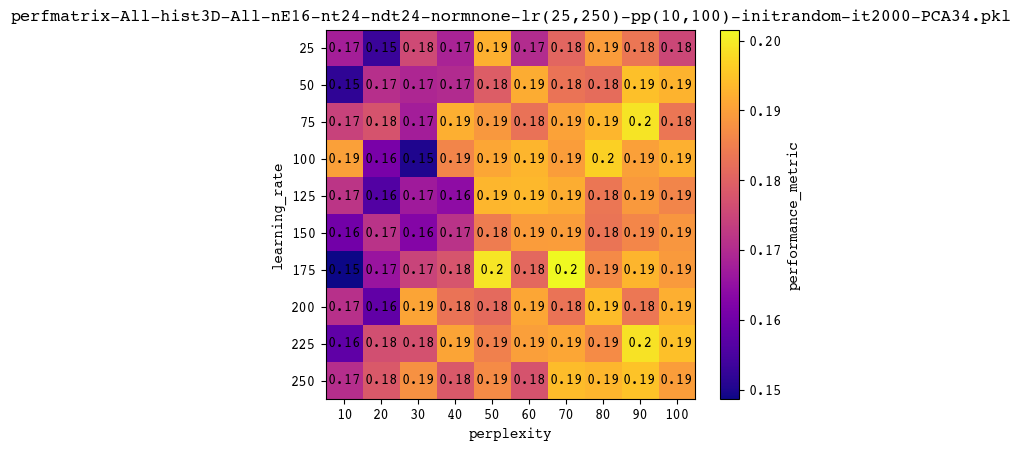

In [47]:
# Load the DataFrame from the CSV file
learning_rates = [25, 50, 75, 100, 125, 150,175,200,225,250] #[50,100,150,200,250,300,350,400,450,500] #[25, 50, 75, 100, 125, 150,175,200,225,250]
perplexities = [10,20,30,40,50,60, 70,80,90,100]
# load the matrix from the file
perf_string = perf_widget.value
parts_string = perf_string .split('-')
with open(f'{global_path}/{set_id}/{perf_string }', 'rb') as f:
    performance_matrix = pickle.load(f)

fig, ax = plt.subplots()
# Define Font Settings
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.monospace'] = "Courier"
plt.rcParams["font.family"] = "monospace"

im = ax.imshow(performance_matrix, cmap='plasma')
ax.set_yticks(np.arange(len(learning_rates)),labels = learning_rates)
ax.set_ylabel('learning_rate')
ax.set_xticks(np.arange(len(perplexities)), labels = perplexities)
ax.set_xlabel('perplexity')
ax.grid(False) 
ax.set_title(perf_string)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("performance_metric")
# Loop over data dimensions and create text annotations.
for i in range(len(learning_rates)):
    for j in range(len(perplexities)):
        text = ax.text(j, i, round(performance_matrix[i, j],2),
                       ha="center", va="center", color="black")
        